In [13]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from GPyEm import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from torch.nn import Parameter

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.ops.stats as stats

In [17]:
mode_weights = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/modes_weights.csv',index_col=0,delim_whitespace=False,header=0)

mode_weights

#mode_weights=mode_weights.drop(15,axis=0)
#mode_weights=mode_weights.drop(14,axis=0)

meshes=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','16','17','18','19']

x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/input/xlabels_EP.txt',delim_whitespace=True,header=None)
x_labels=x_labels.values.flatten().tolist()+mode_weights.columns.tolist()

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/output/ylabels.txt',delim_whitespace=True,header=None)


same_input=[]
same_output=[]

dif_input = []
dif_output=[]
dif_modes=[]

all_input_dif = []
all_output_dif=[]
all_x_dif=[]
for i in range(len(meshes)):
    val=meshes[i]
    
    same_in = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/same_X/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    same_out = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/same_X/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    
    dif_in = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    dif_out = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    
    modeweights = np.tile(mode_weights.iloc[i,:].values, (dif_in.shape[0],1))
    input_modes = np.concatenate((dif_in,modeweights),axis=1)
    same_input.append(torch.tensor(same_in))
    same_output.append(torch.tensor(same_out))
    dif_input.append(torch.tensor(dif_in))
    dif_output.append(torch.tensor(dif_out))
    dif_modes.append(torch.tensor(input_modes))

#all_input=pd.concat(all_input)
#all_output=pd.concat(all_output
#all_input.columns=x_labels
#all_output.columns=y_labels

In [18]:
test=torch.tensor([[1,2,3,4,5,6],[3,2,3,4,5,6]])

In [19]:
test

tensor([[1, 2, 3, 4, 5, 6],
        [3, 2, 3, 4, 5, 6]])

In [23]:
torch.argmax(test,axis=0)

tensor([1, 0, 0, 0, 0, 0])

In [24]:
train_input=[]
test_input = []
train_output=[]
test_output = []

train_input_modes=[]
test_input_modes = []
train_output_modes=[]
test_output_modes = []

for i in range(len(meshes)):

    X=dif_input[i]
    y=dif_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input.append(X_train)
    test_input.append(X_test)
    train_output.append(y_train)
    test_output.append(y_test)
    
    X=dif_modes[i]
    y=dif_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input_modes.append(X_train)
    test_input_modes.append(X_test)
    train_output_modes.append(y_train)
    test_output_modes.append(y_test)

    
    

# GP-LVM Tests

In [28]:
n_sims = 20

In [30]:
c=np.random.choice(range(180),n_sims,replace=False).tolist()

In [33]:
same_output[0][c,0][:,None].shape


torch.Size([20, 1])

In [35]:
A_TAT_all = same_output[0][c,[0]][:,None]

for i in range(len(same_output)-1):
    A_TAT_all=torch.cat((A_TAT_all,same_output[i+1][c,[0]][:,None]),axis=1)
V_TAT_all = same_output[0][c,[1]][:,None]
for i in range(len(same_output)-1):
    V_TAT_all=torch.cat((V_TAT_all,same_output[i+1][c,[1]][:,None]),axis=1)

In [37]:
y=torch.cat([A_TAT_all,V_TAT_all])

In [39]:
y.shape

torch.Size([40, 18])

In [41]:
feats=9

In [43]:
# we setup the mean of our prior over X
X_prior_mean = torch.zeros(y.size(1), feats).double()  # shape: 437 x 2

In [45]:
X = Parameter(X_prior_mean.clone())
kernel = gp.kernels.RBF(input_dim=feats, lengthscale=torch.ones(feats))

In [47]:
# we will use SparseGPRegression model with num_inducing=32;
# initial values for Xu are sampled randomly from X_prior_mean
Xu = stats.resample(X_prior_mean.clone(), 18)
gplvm = gp.models.SparseGPRegression(X, y, kernel, Xu, noise=torch.tensor(0.01), jitter=1e-5)

In [49]:
# we use `.to_event()` to tell Pyro that the prior distribution for X has no batch_shape
gplvm.X = pyro.nn.PyroSample(dist.Normal(X_prior_mean, 0.1).to_event())
gplvm.autoguide("X", dist.Normal)

In [51]:
gplvm.X_loc

Parameter containing:
tensor([[-2.3342e-02,  8.3306e-02, -1.3313e-02,  2.5487e-02,  5.6053e-02,
         -4.3698e-02, -5.8172e-03,  1.7947e-01,  3.6514e-02],
        [ 2.5666e-02, -1.5737e-01,  9.4598e-02,  1.2271e-01,  9.9269e-02,
         -3.1472e-02, -2.2393e-04,  1.4979e-02,  1.2981e-03],
        [ 4.0691e-02,  4.0109e-02,  2.2833e-01,  1.4817e-01, -1.3533e-01,
         -2.1607e-01,  2.0081e-01,  3.0414e-02, -7.4107e-02],
        [-4.1894e-02,  1.0727e-01, -4.6512e-02, -1.1794e-01,  1.6730e-02,
          3.6122e-02, -6.7338e-02,  4.0672e-02, -2.1579e-02],
        [ 7.0726e-02,  8.8271e-03,  6.9392e-02, -1.5769e-01,  2.3295e-01,
          1.5519e-02,  6.0597e-02, -2.5428e-02,  3.8749e-02],
        [-2.9350e-02,  9.9980e-03, -5.0836e-02, -7.3762e-02,  7.9701e-03,
          2.4155e-02, -5.0314e-02, -5.3103e-02, -6.1043e-02],
        [ 2.8192e-01, -3.7721e-02,  3.7255e-02,  6.1063e-02, -1.2137e-01,
          2.6183e-02,  7.5270e-02,  5.6580e-03, -8.1684e-02],
        [ 6.9896e-02,  9.0

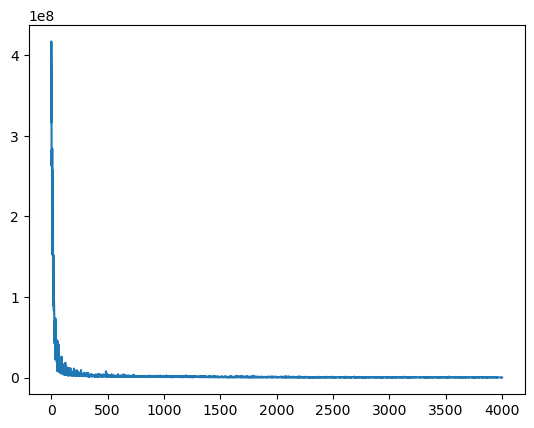

In [53]:
# note that training is expected to take a minute or so
losses = gp.util.train(gplvm, num_steps=4000)

# let's plot the loss curve after 4000 steps of training
plt.plot(losses)
plt.show()

In [54]:
gplvm.X_loc

Parameter containing:
tensor([[-1.5030,  0.1726,  0.0800,  0.3729, -0.2260, -0.0810,  0.1557, -0.0363,
          0.5703],
        [-0.0645,  0.0641,  0.1275,  0.4175, -0.1223, -0.0869, -0.0046,  0.0463,
         -0.1530],
        [-0.0080,  0.1692, -0.0141,  0.1783, -0.1530, -0.1729,  0.0220,  0.1232,
         -0.1535],
        [ 0.3244,  0.0154,  0.1193,  0.0346,  0.0326,  0.0345, -0.2436,  0.0515,
         -0.1312],
        [ 0.3063,  0.0374, -0.0224, -0.0305,  0.3947, -0.0674,  0.1527,  0.3835,
         -0.1778],
        [ 0.0999, -0.2481,  0.1480, -0.2635,  0.1586, -0.0099, -0.1188,  0.0303,
         -0.2538],
        [ 0.4890, -0.3745,  0.0623, -0.4287,  0.2023,  0.3011, -0.2601, -0.0284,
          0.1143],
        [ 0.6038, -0.1792, -0.0923,  0.2505,  0.2357, -0.0275,  0.1020, -0.1326,
         -0.1385],
        [ 0.3261, -0.1827,  0.0648,  0.1617, -0.2446, -0.0225,  0.0320,  0.1959,
         -0.1435],
        [-0.8414,  0.1347,  0.0763,  0.2550, -0.3477,  0.1147,  0.0872,  0.047

In [55]:
X.shape

torch.Size([18, 9])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


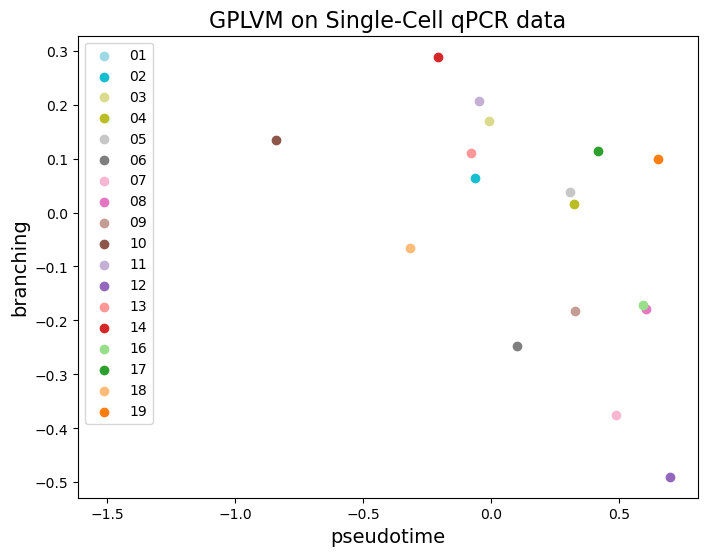

In [56]:
plt.figure(figsize=(8, 6))
colors = plt.get_cmap("tab20").colors[::-1]
labels = meshes

X = gplvm.X_loc
Xs = torch.split(X,1)
for i, label in enumerate(labels):
    print(i)
    X_i = Xs[i].detach().numpy()
    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], label=label)

plt.legend()
plt.xlabel("pseudotime", fontsize=14)
plt.ylabel("branching", fontsize=14)
plt.title("GPLVM on Single-Cell qPCR data", fontsize=16)
plt.show()

In [57]:
gp_modes=[]
d = {}
k = {}
X = {}
f = np.linspace(3,10,8)
for m in range(len(f)):

    feats=int(f[m])
    # we setup the mean of our prior over X
    X_prior_mean = torch.zeros(y.size(1), feats).double()  # shape: 437 x 2
    
    X["string{0}".format(m)] = Parameter(X_prior_mean.clone())
    k["string{0}".format(m)] = gp.kernels.RBF(input_dim=feats, lengthscale=torch.ones(feats))

    # we will use SparseGPRegression model with num_inducing=32;
    # initial values for Xu are sampled randomly from X_prior_mean
    d["string{0}".format(m)] = gp.models.GPRegression(X["string{0}".format(m)], y, k["string{0}".format(m)], noise=torch.tensor(0.01), jitter=1e-5)

    # we use `.to_event()` to tell Pyro that the prior distribution for X has no batch_shape
    d["string{0}".format(m)].X = pyro.nn.PyroSample(dist.Normal(X_prior_mean, 0.1).to_event())
    d["string{0}".format(m)].autoguide("X", dist.Normal)
    #gp.util.train(d["string{0}".format(m)], num_steps=4000)
    #gp_modes.append(d["string{0}".format(m)].X_loc)
    print(m)

0
1
2
3
4
5
6
7


In [58]:
for gpe in d:
    losses=gp.util.train(d[gpe], num_steps=4000)
    gp_modes.append(d[gpe].X_loc)


RuntimeError: The size of tensor a (3) must match the size of tensor b (9) at non-singleton dimension 1
Trace Shapes:     
 Param Sites:     
        X_loc 18 9
      X_scale 18 9
Sample Sites:     

In [ ]:
k

In [ ]:
#gp.util.train(d["string{0}".format(m)], num_steps=4000)
    #gp_modes.append(d["string{0}".format(m)].X_loc)

In [ ]:
d['string4'].X

In [ ]:
gp_modes

In [ ]:
X.shape

In [ ]:
all_input_gp=[]
test_input_gp=[]
test_output_gp=[]
train_input_gp=[]
train_output_gp=[] 
for i in range(len(meshes)):
    val=meshes[i]
    
    inputData = dif_input[i]
    modeweights = torch.tile(X[i,:], (inputData.shape[0],1))
    input_modes = torch.cat((inputData,modeweights),axis=1)
    all_input_gp.append(torch.tensor(input_modes))
    
for i in range(len(meshes)):

    X=all_input_gp[i]
    y=dif_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input_gp.append(X_train)
    test_input_gp.append(X_test)
    train_output_gp.append(y_train)
    test_output_gp.append(y_test)


In [ ]:
reps = 5
train_p = np.linspace(100,800,8)
train_p=np.array([10,15,20,25,30,35,40,45,50])*17
R2_test = torch.zeros(len(train_p),reps,len(meshes),2)
R2_leftout= torch.zeros(len(train_p),reps,len(meshes),2)

R2_test_gp = torch.zeros(len(train_p),reps,len(meshes),2)
R2_leftout_gp= torch.zeros(len(train_p),reps,len(meshes),2)
for k in range(len(train_p)):
    for i in range(len(meshes)):
        for j in range(reps):
            X=torch.cat(train_input_modes[0:i]+train_input_modes[i+1:])[:,0:15]
            y=torch.cat(train_output_modes[:i]+train_output_modes[i+1:])
            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y,
                train_size=int(train_p[k]),
                random_state=j
            )
            X_test= torch.cat(test_input_modes[0:i]+test_input_modes[i+1:])[:,0:15]
            y_test=torch.cat(test_output_modes[:i]+test_output_modes[i+1:])
            emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

            meanR, stdR = emulator.R2_sample(X_test,y_test,1000)
            R2_test[k,j,i,:]=meanR

            meanR, stdR=emulator.R2_sample(test_input_modes[i][:,0:15],test_output_modes[i],1000) 
            R2_leftout[k,j,i,:] = meanR
            print(R2_test[k,j,i,:])
            print(R2_leftout[k,j,i,:])
            
            X=torch.cat(train_input_gp[0:i]+train_input_gp[i+1:])
            y=torch.cat(train_output_gp[:i]+train_output_gp[i+1:])
            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y,
                train_size=int(train_p[k]),
                random_state=j
            )
            X_test= torch.cat(test_input_gp[0:i]+test_input_gp[i+1:])
            y_test=torch.cat(test_output_gp[:i]+test_output_gp[i+1:])
            emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

            meanR, stdR = meanR, stdR = emulator.R2_sample(X_test,y_test,1000)
            R2_test_gp[k,j,i,:]=meanR

            meanR, stdR=emulator.R2_sample(test_input_gp[i],test_output_gp[i],1000) 
            R2_leftout_gp[k,j,i,:] = meanR
            print(R2_test_gp[k,j,i,:])
            print(R2_leftout_gp[k,j,i,:])

1
tensor([0.9974, 0.9948])
tensor([ 0.7109, -0.3641])
0
1
tensor([0.9968, 0.9918])
tensor([-0.4451,  0.7359])
0
1
tensor([0.9973, 0.9939])
tensor([ 0.9119, -0.7913])
0
1
tensor([0.9961, 0.9916])
tensor([-0.7596,  0.6624])
0
1
tensor([0.9977, 0.9945])
tensor([-0.2655,  0.9117])
0
1
tensor([0.9961, 0.9921])
tensor([0.8423, 0.2747])
0
1
tensor([0.9975, 0.9943])
tensor([-0.2888,  0.8120])
0
1
tensor([0.9963, 0.9912])
tensor([0.8838, 0.6542])
0
1
tensor([0.9978, 0.9942])
tensor([-0.2200,  0.9036])
0
1
tensor([0.9976, 0.9933])
tensor([-0.2187,  0.8144])
0
1
tensor([0.9977, 0.9947])
tensor([-0.2103,  0.8731])
0
1
tensor([0.9972, 0.9915])
tensor([-0.1851,  0.8225])
0
1
tensor([0.9973, 0.9939])
tensor([-0.2241,  0.9202])
0
1
tensor([0.9966, 0.9917])
tensor([-0.1132, -1.3907])
0
1
tensor([0.9974, 0.9946])
tensor([0.8891, 0.9659])
0
1
tensor([0.9965, 0.9922])
tensor([-3.8737, -0.8559])
0
1
tensor([0.9972, 0.9942])
tensor([-0.4113,  0.9662])
0
1
tensor([0.9968, 0.9913])
tensor([-2.0377,  0.0439])


1
tensor([0.9969, 0.9920])
tensor([-1.3909, -0.1906])
0
1
tensor([0.9975, 0.9941])
tensor([0.9285, 0.9563])
0
1
tensor([0.9971, 0.9929])
tensor([-0.1274, -0.0009])
0
1
tensor([0.9975, 0.9945])
tensor([0.9175, 0.3012])
0
1
tensor([0.9972, 0.9927])
tensor([0.9896, 0.9221])
0
1
tensor([0.9974, 0.9946])
tensor([-0.4437,  0.0076])
0
1
tensor([0.9970, 0.9925])
tensor([0.9620, 0.9367])
0
1
tensor([0.9976, 0.9947])
tensor([-1.0080, -0.0430])
0
1
tensor([0.9962, 0.9928])
tensor([0.9919, 0.9423])
0
1
tensor([0.9977, 0.9949])
tensor([-0.5661, -0.0511])
0
1
tensor([0.9972, 0.9939])
tensor([0.9723, 0.9415])
0
1
tensor([0.9977, 0.9934])
tensor([-0.7360,  0.1888])
0
1
tensor([0.9970, 0.9940])
tensor([0.9719, 0.9615])
0
1
tensor([0.9970, 0.9942])
tensor([0.9705, 0.8449])
0
1
tensor([0.9972, 0.9915])
tensor([0.8759, 0.9308])
0
1
tensor([0.9974, 0.9945])
tensor([0.9677, 0.8768])
0
1
tensor([0.9968, 0.9918])
tensor([0.8286, 0.9039])
0
1
tensor([0.9971, 0.9946])
tensor([0.6365, 0.9432])
0
1
tensor([0.9962

1
tensor([0.9980, 0.9949])
tensor([0.8980, 0.8358])
0
1
tensor([0.9969, 0.9934])
tensor([-1.0827,  0.3933])
0
1
tensor([0.9973, 0.9952])
tensor([0.9482, 0.8187])
0
1
tensor([0.9972, 0.9938])
tensor([0.5670, 0.6071])
0
1
tensor([0.9971, 0.9950])
tensor([-0.4454,  0.8748])
0
1
tensor([0.9975, 0.9936])
tensor([0.6485, 0.7119])
0
1
tensor([0.9980, 0.9947])
tensor([0.9352, 0.9416])
0
1
tensor([0.9971, 0.9939])
tensor([0.7273, 0.9081])
0
1
tensor([0.9981, 0.9952])
tensor([0.7735, 0.8599])
0
1
tensor([0.9974, 0.9935])
tensor([0.8875, 0.2048])
0
1
tensor([0.9975, 0.9950])
tensor([0.9150, 0.7943])
0
1
tensor([0.9965, 0.9916])
tensor([0.6348, 0.0494])
0
1
tensor([0.9979, 0.9951])
tensor([0.8140, 0.9655])
0
1
tensor([0.9974, 0.9940])
tensor([0.8956, 0.9775])
0
1
tensor([0.9979, 0.9944])
tensor([0.7354, 0.9625])
0
1
tensor([0.9966, 0.9937])
tensor([0.9067, 0.9789])
0
1
tensor([0.9981, 0.9951])
tensor([0.7501, 0.9003])
0
1
tensor([0.9970, 0.9940])
tensor([0.9573, 0.9606])
0
1
tensor([0.9979, 0.9948

1
tensor([0.9974, 0.9940])
tensor([0.5733, 0.6152])
0
1
tensor([0.9980, 0.9964])
tensor([0.4197, 0.9513])
0
1
tensor([0.9976, 0.9941])
tensor([ 0.8101, -0.8696])
0
1
tensor([0.9981, 0.9955])
tensor([0.6399, 0.9516])
0
1
tensor([0.9976, 0.9938])
tensor([0.4251, 0.1848])
0
1
tensor([0.9981, 0.9956])
tensor([0.9727, 0.9488])
0
1
tensor([0.9975, 0.9939])
tensor([ 0.8388, -0.4162])
0
1
tensor([0.9983, 0.9954])
tensor([0.4586, 0.8790])
0
1
tensor([0.9971, 0.9950])
tensor([0.7589, 0.0525])
0
1
tensor([0.9980, 0.9959])
tensor([0.5336, 0.9422])
0
1
tensor([0.9973, 0.9938])
tensor([0.8677, 0.2467])
0
1
tensor([0.9979, 0.9962])
tensor([0.9780, 0.9619])
0
1
tensor([0.9977, 0.9954])
tensor([0.9837, 0.9561])
0
1
tensor([0.9982, 0.9958])
tensor([0.9909, 0.9250])
0
1
tensor([0.9978, 0.9941])
tensor([0.9922, 0.9560])
0
1
tensor([0.9982, 0.9958])
tensor([0.9906, 0.9057])
0
1
tensor([0.9977, 0.9949])
tensor([0.9965, 0.9725])
0
1
tensor([0.9978, 0.9958])
tensor([0.9913, 0.9354])
0
1
tensor([0.9976, 0.9960

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/operators/_linear_operator.py:2155: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(


tensor([0.9781, 0.9856])
tensor([ 0.7281, -0.5124])
0
1
tensor([0.9792, 0.9848])
tensor([-0.1909,  0.6607])
0
1
tensor([0.9733, 0.9831])
tensor([ 0.9074, -0.0093])
0
1
tensor([0.9750, 0.9673])
tensor([-0.6166,  0.6140])
0
1
tensor([0.9800, 0.9871])
tensor([ 0.9322, -0.4119])
0
1
tensor([0.9782, 0.9871])
tensor([-0.2668, -0.1685])
0
1
tensor([0.9855, 0.9901])
tensor([ 0.8916, -0.3798])
0
1
tensor([0.9796, 0.9840])
tensor([-0.4671,  0.7281])
0
1
tensor([0.9780, 0.9880])
tensor([ 0.9091, -0.4070])
0
1
tensor([0.9798, 0.9857])
tensor([-0.0876,  0.7291])
0
1
tensor([0.9741, 0.9868])
tensor([-0.4992,  0.9080])
0
1
tensor([0.9858, 0.9858])
tensor([0.8732, 0.8226])
0
1
tensor([0.9766, 0.9860])
tensor([-0.4236,  0.7709])
0
1
tensor([0.9820, 0.9781])
tensor([-0.2563,  0.7609])
0
1
tensor([0.9846, 0.9865])
tensor([-0.0950,  0.9141])
0
1
tensor([0.9784, 0.9841])
tensor([0.0416, 0.8125])
0
1
tensor([0.9812, 0.9909])
tensor([-0.2701,  0.9210])
0
1
tensor([0.9819, 0.9866])
tensor([0.7994, 0.7784])
0


1
tensor([0.9789, 0.9855])
tensor([0.2581, 0.7001])
0
1
tensor([0.9772, 0.9827])
tensor([0.8589, 0.9400])
0
1
tensor([0.9760, 0.9826])
tensor([ 0.2486, -0.2912])
0
1
tensor([0.9816, 0.9791])
tensor([0.9582, 0.9381])
0
1
tensor([0.9829, 0.9793])
tensor([0.0783, 0.7216])
0
1
tensor([0.9785, 0.9834])
tensor([0.9573, 0.9755])
0
1
tensor([0.9836, 0.9815])
tensor([0.5621, 0.6774])
0
1
tensor([0.9831, 0.9889])
tensor([0.9472, 0.9519])
0
1
tensor([0.9879, 0.9783])
tensor([0.2422, 0.2624])
0
1
tensor([0.9838, 0.9872])
tensor([-0.3972,  0.0986])
0
1
tensor([0.9877, 0.9834])
tensor([0.9649, 0.8696])
0
1
tensor([0.9796, 0.9845])
tensor([-0.2246,  0.1926])
0
1
tensor([0.9802, 0.9861])
tensor([0.9615, 0.8877])
0
1
tensor([0.9806, 0.9835])
tensor([-0.5312,  0.1619])
0
1
tensor([0.9848, 0.9761])
tensor([0.9730, 0.8981])
0
1
tensor([0.9774, 0.9834])
tensor([-0.2772,  0.6319])
0
1
tensor([0.9849, 0.9771])
tensor([0.9748, 0.8873])
0
1
tensor([0.9836, 0.9889])
tensor([-0.4431,  0.6664])
0
1
tensor([0.9873

In [ ]:
i

In [ ]:
meanR

In [ ]:
800/17

In [ ]:
R2_test.mean(axis=[1,2])[:8].detach()

In [ ]:
R2_test_gp.mean(axis=[1,2])[:8].detach()

In [ ]:
R2_leftout.mean(axis=[1,2])[:8].detach()

In [ ]:
R2_leftout_gp.mean(axis=[1,2])[:8]

In [ ]:
fontS=12

In [ ]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(train_p[:8],R2_test.mean(axis=[1,2])[:8,0].detach().numpy(),fmt='o',yerr=R2_test.std(axis=[1,2])[:8,0].detach().numpy())
plt.errorbar(train_p[:8],R2_test.mean(axis=[1,2])[:8,1].detach().numpy(),fmt='o',yerr=R2_test.std(axis=[1,2])[:8,1].detach().numpy())

plt.errorbar(train_p[:8],R2_test_gp.mean(axis=[1,2])[:8,0].detach().numpy(),fmt='o',yerr=R2_test_gp.std(axis=[1,2])[:8,0].detach().numpy())
plt.errorbar(train_p[:8],R2_test_gp.mean(axis=[1,2])[:8,1].detach().numpy(),fmt='o',yerr=R2_test_gp.std(axis=[1,2])[:8,1].detach().numpy())

plt.legend(('A_TAT','V_TAT','A_TAT GP','V_TAT GP'),fontsize=fontS)
plt.xlabel('Training Points',fontsize=fontS)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('figures/WeavingDTLatentNLeftin.pdf' )

In [ ]:
R2_test.mean(axis=[1,2])[:7,]

In [ ]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(train_p[:7],R2_leftout.mean(axis=[1,2])[:7,0].detach().numpy(),fmt='o',yerr=R2_leftout.std(axis=[1,2])[:7,0].detach().numpy())
plt.errorbar(train_p[:7],R2_leftout.mean(axis=[1,2])[:7,1].detach().numpy(),fmt='o',yerr=R2_leftout.std(axis=[1,2])[:7,1].detach().numpy())

plt.errorbar(train_p[:7],R2_leftout_gp.mean(axis=[1,2])[:7,0].detach().numpy(),fmt='o',yerr=R2_leftout_gp.std(axis=[1,2])[:7,0].detach().numpy())
plt.errorbar(train_p[:7],R2_leftout_gp.mean(axis=[1,2])[:7,1].detach().numpy(),fmt='o',yerr=R2_leftout_gp.std(axis=[1,2])[:7,1].detach().numpy())

plt.legend(('A_TAT','V_TAT','A_TAT GP','V_TAT GP'),fontsize=fontS)
plt.xlabel('Training Points',fontsize=fontS)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xticks(fontsize=fontS) 
plt.yticks(fontsize=fontS)
plt.savefig('figures/WeavingDTLatentNLeftout.pdf' )

In [59]:
np.linspace(1,9,9)

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [80]:
len(meshes)

18

In [81]:
X_prior_mean

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

In [82]:
y

tensor([[143.8950, 108.6710, 102.8900, 100.2590,  92.7805,  95.0455,  95.1232,
          92.1625,  98.0163, 121.0550, 112.5890,  85.1008, 107.1970, 108.3480,
          90.6607, 107.6410,  83.5767,  79.9982],
        [165.9600, 137.3160, 123.2540, 116.3570, 108.5430, 103.0250, 105.0770,
         100.9970, 108.1630, 131.8010, 130.4560, 100.0900, 125.6000, 123.6160,
         104.4840, 121.0420,  93.8847,  95.6497],
        [144.8360, 118.5100, 115.1750, 111.2700, 103.7620, 100.5810,  99.0901,
          96.1436, 106.2490, 130.1110, 117.8410,  92.7882, 116.0340, 117.8350,
          96.5547, 110.6310,  86.4705,  92.2660],
        [145.0060, 112.8790, 112.7560, 111.0230, 102.0860, 100.6960, 104.5640,
         100.4760, 108.9850, 129.6270, 118.6570,  94.7622, 115.7590, 120.7550,
          95.9507, 114.3700,  87.5293,  91.6855],
        [206.5860, 165.5050, 155.7970, 149.3620, 138.5510, 135.6540, 132.6090,
         127.2070, 137.4690, 172.8670, 166.1770, 123.3990, 160.5730, 158.3280,
         1

In [83]:
y=torch.cat([A_TAT_all,V_TAT_all])

In [85]:
gp_modes=[]
f = np.linspace(3,10,8)
for m in range(len(f)):
    
    feats=int(f[m])

    # we setup the mean of our prior over X
    X_prior_mean = torch.zeros(y.size(1), feats).double()  # shape: 437 x 2

    X = Parameter(X_prior_mean.clone())
    kernel = gp.kernels.RBF(input_dim=feats, lengthscale=torch.ones(feats))

    # we will use SparseGPRegression model with num_inducing=32;
    # initial values for Xu are sampled randomly from X_prior_mean
    Xu = stats.resample(X_prior_mean.clone(), 18)
    gplvm = gp.models.SparseGPRegression(X, y, kernel, Xu, noise=torch.tensor(0.01), jitter=1e-5)

    # we use `.to_event()` to tell Pyro that the prior distribution for X has no batch_shape
    gplvm.X = pyro.nn.PyroSample(dist.Normal(X_prior_mean, 0.1).to_event())
    gplvm.autoguide("X", dist.Normal)
    losses = gp.util.train(gplvm, num_steps=4000)
    gp_modes.append(gplvm.X_loc)
    print(m)

RuntimeError: The size of tensor a (3) must match the size of tensor b (9) at non-singleton dimension 1
Trace Shapes:     
 Param Sites:     
        X_loc 18 9
      X_scale 18 9
Sample Sites:     

In [ ]:

reps=5
R2_test = torch.zeros(len(f),reps,len(meshes),2)
R2_leftout = torch.zeros(len(f),reps,len(meshes),2)
for m in range(len(f)):
    X=gp_modes[m]
    all_input_gp=[]
    test_input_gp=[]
    test_output_gp=[]
    train_input_gp=[]
    train_output_gp=[] 
    for i in range(len(meshes)):
        val=meshes[i]

        inputData = dif_input[i]
        modeweights = torch.tile(X[i,:], (inputData.shape[0],1))
        input_modes = torch.cat((inputData,modeweights),axis=1)
        all_input_gp.append(torch.tensor(input_modes))
        print(input_modes.shape)
    for i in range(len(meshes)):

        X=all_input_gp[i]
        y2=dif_output[i]
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y2,
            test_size=0.2,
            random_state=seed+i
        )
        train_input_gp.append(X_train)
        test_input_gp.append(X_test)
        train_output_gp.append(y_train)
        test_output_gp.append(y_test)
        
    for i in range(len(meshes)):
        for j in range(reps):

            X=torch.cat(train_input_gp[0:i]+train_input_gp[i+1:])
            y2=torch.cat(train_output_gp[:i]+train_output_gp[i+1:])
            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y2,
                train_size=int(45*17),
                random_state=j
            )
            X_test= torch.cat(test_input_gp[0:i]+test_input_gp[i+1:])
            y_test=torch.cat(test_output_gp[:i]+test_output_gp[i+1:])
            emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

            meanR, stdR = meanR, stdR = emulator.R2_sample(X_test,y_test,1000)
            R2_test[m,j,i,:]=meanR

            meanR, stdR=emulator.R2_sample(test_input_gp[i],test_output_gp[i],1000) 
            R2_leftout[m,j,i,:] = meanR
            print(R2_test[m,j,i,:])
            print(R2_leftout[m,j,i,:])


1
tensor([0.9973, 0.9935])
tensor([0.8573, 0.1113])
0
1
tensor([0.9978, 0.9934])
tensor([0.9541, 0.9185])
0
1
tensor([0.9981, 0.9940])
tensor([0.9328, 0.9176])
0
1
tensor([0.9981, 0.9928])
tensor([0.9402, 0.8475])
0
1
tensor([0.9982, 0.9926])
tensor([0.9287, 0.9228])
0
1
tensor([0.9978, 0.9936])
tensor([0.9476, 0.9319])
0
1
tensor([0.9972, 0.9941])
tensor([0.9804, 0.9305])
0
1
tensor([0.9982, 0.9942])
tensor([0.9823, 0.9341])
0
1
tensor([0.9978, 0.9931])
tensor([0.9817, 0.7482])
0
1
tensor([0.9980, 0.9940])
tensor([0.9733, 0.9264])
0
1
tensor([0.9973, 0.9929])
tensor([0.9786, 0.8548])
0
1
tensor([0.9977, 0.9952])
tensor([0.9928, 0.8489])
0
1
tensor([0.9981, 0.9937])
tensor([0.9860, 0.8794])
0
1
tensor([0.9974, 0.9946])
tensor([0.9913, 0.8127])
0
1
tensor([0.9977, 0.9943])
tensor([0.9924, 0.8556])
0
1
tensor([0.9977, 0.9937])
tensor([0.9915, 0.8684])
0
1
tensor([0.9973, 0.9940])
tensor([0.9694, 0.1767])
0
1
tensor([0.9981, 0.9938])
tensor([0.9171, 0.5440])
0
1
tensor([0.9975, 0.9940])
t

1
tensor([0.9975, 0.9952])
tensor([0.8891, 0.8438])
0
1
tensor([0.9977, 0.9949])
tensor([0.9447, 0.8839])
0
1
tensor([0.9974, 0.9944])
tensor([-0.4602,  0.5976])
0
1
tensor([0.9977, 0.9947])
tensor([0.2264, 0.5215])
0
1
tensor([0.9975, 0.9958])
tensor([ 0.0534, -2.2727])
0
1
tensor([0.9973, 0.9951])
tensor([-0.1928, -0.9778])
0
1
tensor([0.9975, 0.9945])
tensor([0.3803, 0.0257])
0
1
tensor([0.9973, 0.9948])
tensor([0.9149, 0.4992])
0
1
tensor([0.9966, 0.9952])
tensor([0.9246, 0.4013])
0
1
tensor([0.9974, 0.9960])
tensor([0.4872, 0.4621])
0
1
tensor([0.9977, 0.9955])
tensor([0.4070, 0.6757])
0
1
tensor([0.9974, 0.9952])
tensor([0.9663, 0.5481])
0
1
tensor([0.9977, 0.9945])
tensor([-0.3571,  0.8085])
0
1
tensor([0.9978, 0.9952])
tensor([-0.3871,  0.8449])
0
1
tensor([0.9977, 0.9954])
tensor([-0.3676,  0.7984])
0
1
tensor([0.9980, 0.9946])
tensor([-0.5218,  0.8377])
0
1
tensor([0.9977, 0.9944])
tensor([-0.3016,  0.8370])
0
1
tensor([0.9976, 0.9944])
tensor([0.6840, 0.9126])
0
1
tensor([0.

1
tensor([0.9979, 0.9949])
tensor([0.8641, 0.9209])
0
1
tensor([0.9978, 0.9948])
tensor([0.7906, 0.5354])
0
1
tensor([0.9985, 0.9960])
tensor([0.7429, 0.3957])
0
1
tensor([0.9978, 0.9947])
tensor([0.7523, 0.3760])
0
1
tensor([0.9978, 0.9955])
tensor([0.7632, 0.2160])
0
1
tensor([0.9979, 0.9954])
tensor([0.6653, 0.9046])
0
1
tensor([0.9978, 0.9954])
tensor([-1.8584,  0.9103])
0
1
tensor([0.9983, 0.9952])
tensor([-4.7986, -1.3967])
0
1
tensor([0.9981, 0.9953])
tensor([-3.8604,  0.9520])
0
1
tensor([0.9981, 0.9960])
tensor([-3.8507,  0.9353])
0
1
tensor([0.9981, 0.9951])
tensor([-2.0610,  0.8865])
0
1
tensor([0.9979, 0.9953])
tensor([0.9147, 0.7536])
0
1
tensor([0.9982, 0.9956])
tensor([0.8579, 0.4687])
0
1
tensor([0.9979, 0.9945])
tensor([0.8714, 0.8283])
0
1
tensor([0.9980, 0.9959])
tensor([0.9393, 0.7595])
0
1
tensor([0.9975, 0.9951])
tensor([0.7191, 0.7132])
0
1
tensor([0.9980, 0.9944])
tensor([0.2393, 0.9527])
0
1
tensor([0.9983, 0.9955])
tensor([0.7924, 0.9259])
0
1
tensor([0.9978, 

1
tensor([0.9978, 0.9953])
tensor([0.6201, 0.9190])
0
1
tensor([0.9974, 0.9955])
tensor([0.6583, 0.9628])
0
1
tensor([0.9978, 0.9950])
tensor([0.8820, 0.8976])
0
1
tensor([0.9972, 0.9951])
tensor([0.7532, 0.9013])
0
1
tensor([0.9979, 0.9961])
tensor([0.7700, 0.8729])
0
1
tensor([0.9976, 0.9956])
tensor([0.8517, 0.9444])
0
1
tensor([0.9975, 0.9955])
tensor([0.8681, 0.8938])
0
1
tensor([0.9975, 0.9956])
tensor([0.5868, 0.5250])
0
1
tensor([0.9972, 0.9953])
tensor([0.1752, 0.7718])
0
1
tensor([0.9978, 0.9958])
tensor([0.4938, 0.7077])
0
1
tensor([0.9978, 0.9953])
tensor([0.4002, 0.3669])
0
1
tensor([0.9976, 0.9957])
tensor([0.4804, 0.3601])
0
1
tensor([0.9978, 0.9955])
tensor([-3.6527,  0.1580])
0
1
tensor([0.9974, 0.9950])
tensor([-4.5444,  0.3022])
0
1
tensor([0.9979, 0.9959])
tensor([-1.5089,  0.2291])
0
1
tensor([0.9977, 0.9949])
tensor([-1.3476,  0.0078])
0
1
tensor([0.9978, 0.9949])
tensor([-0.9456,  0.1060])
0
1
tensor([0.9978, 0.9953])
tensor([0.8962, 0.8884])
0
1
tensor([0.9973, 

In [13]:
X

tensor([[ 0.6823,  0.2297,  7.5578,  ...,  0.4685,  4.3161, -0.2519],
        [ 0.7455,  0.4566,  7.6716,  ...,  0.3531,  5.4738, -0.2519],
        [ 0.6993,  0.2726,  6.3312,  ...,  0.3556,  3.0279, -0.2519],
        ...,
        [ 0.5787,  0.4716,  2.0716,  ...,  0.2841,  5.6434,  0.5360],
        [ 0.7148,  0.2119,  2.5516,  ...,  0.3632,  1.8089,  0.5360],
        [ 0.7724,  0.2202,  3.0978,  ...,  0.3888,  2.0067,  0.5360]],
       dtype=torch.float64)

In [68]:
R2_test_gp

tensor([[[[0.9832, 0.9766],
          [0.9867, 0.9726],
          [0.9860, 0.9787],
          ...,
          [0.9836, 0.9740],
          [0.9862, 0.9741],
          [0.9855, 0.9745]],

         [[0.9839, 0.9742],
          [0.9863, 0.9757],
          [0.9834, 0.9731],
          ...,
          [0.9880, 0.9785],
          [0.9897, 0.9765],
          [0.9871, 0.9771]],

         [[0.9807, 0.9759],
          [0.9828, 0.9776],
          [0.9852, 0.9661],
          ...,
          [0.9810, 0.9656],
          [0.9812, 0.9664],
          [0.9837, 0.9632]],

         [[0.9844, 0.9787],
          [0.9847, 0.9805],
          [0.9862, 0.9785],
          ...,
          [0.9871, 0.9739],
          [0.9909, 0.9732],
          [0.9888, 0.9701]],

         [[0.9828, 0.9597],
          [0.9845, 0.9675],
          [0.9868, 0.9669],
          ...,
          [0.9817, 0.9617],
          [0.9839, 0.9559],
          [0.9855, 0.9558]]],


        [[[0.9910, 0.9806],
          [0.9916, 0.9821],
          [0.9928

In [69]:
i

0

In [70]:
X_train.shape

torch.Size([510, 15])

In [71]:
y_train.shape

torch.Size([510, 2])

In [72]:
gplvm.X_loc

Parameter containing:
tensor([[-2.1950e-01, -3.9588e-02, -9.5533e-02, -1.0962e-01, -1.0015e-01,
          1.1485e-03, -1.8931e-02, -1.5053e-01,  5.7528e-02],
        [-5.8453e-02,  1.0517e-01,  4.2489e-02, -1.3357e-01, -2.0779e-01,
          1.2473e-01,  2.7866e-02,  3.4906e-02,  1.6401e-01],
        [ 2.8786e-02, -1.0925e-01, -1.0522e-01, -7.2013e-02,  1.3301e-01,
          2.0659e-01, -5.1307e-02,  5.5575e-02, -1.2567e-01],
        [ 6.1592e-02, -3.8234e-02, -2.6107e-02,  1.3040e-02,  7.9361e-03,
         -1.3746e-01,  1.6933e-01, -7.8600e-03,  2.1804e-01],
        [ 6.0545e-02, -1.4122e-01,  2.4177e-02,  1.6073e-02, -1.2098e-01,
         -6.6547e-02,  9.3613e-03,  8.7511e-02,  1.8359e-01],
        [ 8.3618e-02, -1.1521e-02, -1.3810e-01, -1.0721e-01,  2.5636e-01,
          6.5815e-02, -8.9664e-02,  2.0668e-02,  5.9149e-02],
        [-3.7121e-02,  7.2995e-02, -6.5655e-02, -1.3744e-01,  2.1161e-01,
         -1.2170e-02, -1.3249e-04, -5.5670e-02, -1.1212e-01],
        [-2.1569e-02, -1.1

In [73]:
f[m]

1.0

In [63]:
m

0

In [34]:
f = np.linspace(3,10,9)

<ErrorbarContainer object of 3 artists>

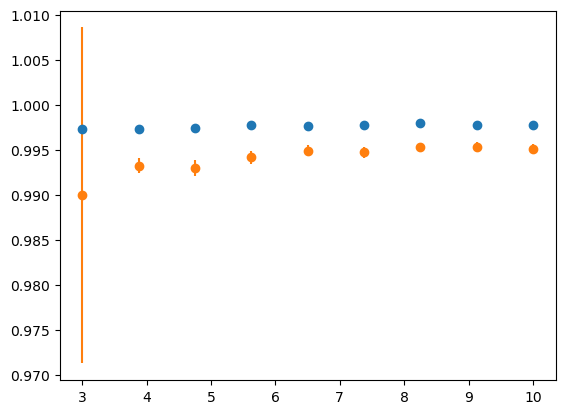

In [37]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(f,R2_test.mean(axis=[1,2])[:,0].detach().numpy(),fmt='o',yerr=R2_test.std(axis=[1,2])[:,0].detach().numpy())
plt.errorbar(f,R2_test.mean(axis=[1,2])[:,1].detach().numpy(),fmt='o',yerr=R2_test.std(axis=[1,2])[:,1].detach().numpy())


In [38]:
meshes=['01','02','03','04','05','06','07','08','09','10']

Ys=[]
Xs=[]

for i in range(len(meshes)):
    val=meshes[i]
    
    inputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val+"/X.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values

    

    Xs.append(torch.tensor(inputData[0:200]))
    Ys.append(torch.tensor(outputData[0:200]))